In [2]:

from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import numpy as np

In [103]:

!ls "/content/drive/My Drive/colab"

cnn		Models	     NLP_yx1201.ipynb  snli_train.tsv
Cnn		Models_CNN   other	       snli_val.tsv
mnli_train.tsv	Models_CNN2  rnn	       wiki-news-300d-1M-subword.vec
mnli_val.tsv	Models_RNN   Rnn


In [104]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

0.4.1
True


In [0]:

assert torch.cuda.is_available and torch.has_cudnn

In [0]:
# First lets improve libraries that we are going to be used in this lab session
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
import pandas as pd
import random
import pickle
from torch.utils.data.sampler import SubsetRandomSampler




In [0]:
train_data= pd.read_csv('/content/drive/My Drive/colab/snli_train.tsv',delimiter='\t',encoding='utf-8')
val_data=pd.read_csv('/content/drive/My Drive/colab/snli_val.tsv',delimiter='\t',encoding='utf-8')

# Transfer string into Word Vectors using FastText

### Load Pre-trained FastText

In [0]:
from collections import OrderedDict
from itertools import islice
import json

In [0]:

import io
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = OrderedDict()
    for line in islice(fin,100000):
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    
    return data
word_embedding = load_vectors("/content/drive/My Drive/colab/wiki-news-300d-1M-subword.vec")

### Build Vocabulary

In [0]:
from collections import Counter

PAD_IDX = 0
UNK_IDX = 1

def build_vocab(vectors):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices

    id2token = list(vectors.keys())
    token2id = dict(zip(list(vectors.keys()), range(2,2+len(vectors)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

#token2id, id2token = build_vocab(all_train_tokens)

In [0]:
token2id, id2token = build_vocab(word_embedding)

In [0]:
word_embedding['<pad>']=map(lambda x:x,[0]*300)
word_embedding['<unk>']=map(lambda x:x,[1]*300)

In [113]:
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 60888 ; token Shootout
Token Shootout; token id 60888


In [0]:
name_mapping = token2id

dic = word_embedding

for old, new in name_mapping.items():
    value = dic.get(old, None)
    if value is None:
        continue

    dic[new] = value
    del dic[old]

In [0]:
from collections import OrderedDict

ordered_id_embedding = OrderedDict(sorted(word_embedding.items()))
embedding_matrix=np.array([list(i) for i in list(ordered_id_embedding.values())]).reshape(100002,300)

#  Process them with data loader

In [116]:
train_data['len1']=train_data['sentence1'].apply(lambda x: len(x.split(" ")))
train_data['len2']=train_data['sentence2'].apply(lambda x: len(x.split(" ")))
max(list(train_data['len1'])),max(list(train_data['len2']))

(82, 41)

In [117]:
max(list(train_data['len1'])),max(list(train_data['len2']))

(82, 41)

In [0]:
def one_hot(df):  
    conditions = [
        (df['label'] == 'neutral') ,
        (df['label'] == 'contradiction'),
        (df['label'] == 'entailment')]
    choices = [0, 1, 2]
    df['Label'] = np.select(conditions, choices)
    
    return df

val_data=one_hot(val_data)
train_data=one_hot(train_data)

In [119]:
# convert token to id in the dataset
# replace each token with its index

def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        tokens=tokens.split(" ")
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
       
        indices_data.append(index_list)
    return indices_data

train_data_indices1 = token2index_dataset(list(train_data['sentence1']))
train_data_indices2 = token2index_dataset(list(train_data['sentence2']))
val_data_indices1 = token2index_dataset(list(val_data['sentence1']))
val_data_indices2 = token2index_dataset(list(val_data['sentence2']))
train_label=train_data["Label"]
val_label=val_data['Label']
#test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset1 size is {}".format(len(train_data_indices1)))
print ("Train dataset2 size is {}".format(len(train_data_indices2)))
print ("Val dataset1 size is {}".format(len(val_data_indices1)))
print ("Val dataset2 size is {}".format(len(val_data_indices2)))


Train dataset1 size is 100000
Train dataset2 size is 100000
Val dataset1 size is 1000
Val dataset2 size is 1000


In [0]:
def tuple_list(data_indices1, data_indices2, label):
    list_tuple=[]
    for i in range(len(label)):
        list_tuple.append((data_indices1[i], data_indices2[i],label[i]))
    
    return list_tuple


In [0]:
train_tuple=tuple_list(train_data_indices1,train_data_indices2,train_label)
val_tuple=tuple_list(val_data_indices1,val_data_indices2,val_label)


In [0]:
MAX_SENTENCE_LENGTH1 = 82
MAX_SENTENCE_LENGTH2 = 41


class NewsGroupDataset(Dataset):
    def __init__(self, data_tuple):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.data_list1, self.data_list2, self.target_list = zip(*data_tuple)
        assert (len(self.data_list1) == len(self.data_list2) == len(self.target_list))

    def __len__(self):
        return len(self.data_list1)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        ## parameter: max_sentence_length 
        ## pick the max length of 80% 90%
        token_idx1 = self.data_list1[key][:MAX_SENTENCE_LENGTH1]
        token_idx2 = self.data_list2[key][:MAX_SENTENCE_LENGTH2]
        label = self.target_list[key]
        return [token_idx1, token_idx2, len(token_idx1), len(token_idx2),label]
    

In [0]:
def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    data_list1 = []
    data_list2 = []
    label_list = []
    length_list1 = []
    length_list2 = []

    for datum in batch:
        label_list.append(datum[4])
        length_list1.append(datum[2])
        length_list2.append(datum[3])
    # padding
 
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_SENTENCE_LENGTH1-datum[2])),
                                mode="constant", constant_values=0)
        padded_vec2 = np.pad(np.array(datum[1]),
                        pad_width=((0,MAX_SENTENCE_LENGTH2-datum[3])),
                        mode="constant", constant_values=0)

        data_list1.append(padded_vec1)
        data_list2.append(padded_vec2)
        
    
   
    return [torch.from_numpy(np.array(data_list1)).cuda(), torch.from_numpy(np.array(data_list2)).cuda(),torch.LongTensor(length_list1).cuda(), torch.LongTensor(length_list2).cuda(),torch.LongTensor(label_list).cuda()]                     
                          

In [0]:
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_tuple)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                          
                                           shuffle=True)

train_loader2 = torch.utils.data.DataLoader(dataset=train_dataset, 
                                          
                                           batch_size=BATCH_SIZE,
                                           sampler=SubsetRandomSampler(range(BATCH_SIZE*800)),
                                          collate_fn=newsgroup_collate_func,
                                           )


val_dataset = NewsGroupDataset(val_tuple)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)


# val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                          
#                                            batch_size=BATCH_SIZE,
#                                            sampler=SubsetRandomSampler(range(BATCH_SIZE*1500)),
#                                           collate_fn=newsgroup_collate_func,
#                                            )


# test_dataset = NewsGroupDataset(test_data_indices, test_targets)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
#                                            batch_size=BATCH_SIZE,
#                                            collate_fn=newsgroup_collate_func,
#                                            shuffle=False)

# RNN

### Feed them separately into the encoder

In [0]:
def create_emb_layer(weights_matrix, non_trainable=False):
    
    '''CITATION: From 'How to use Pre-trained Word Embeddings in PyTorch':
    https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76
    '''
    
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)
    weights_matrix = torch.Tensor(weights_matrix)
    weights_matrix = weights_matrix.cuda()
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = True

    return emb_layer, num_embeddings, embedding_dim



class RNN(nn.Module):
    
    def __init__(self, weights_matrix, hidden_size, num_layers, num_classes, interacting):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(RNN, self).__init__()
        
        self.interacting = interacting
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        self.rnn = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
        self.linear11 = nn.Linear(hidden_size*4, hidden_size)
        self.linear12 = nn.Linear(hidden_size*2, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        
    def init_hidden(self, batch_size):
      
        torch.manual_seed(2)
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        
        ## random array?
        hidden = torch.randn(2*self.num_layers, batch_size, self.hidden_size)
        hidden = hidden.cuda()

        return hidden

    def forward(self, x1, x2, lengths1, lengths2):
        # reset hidden state

#          hidden = torch.randn(2*self.num_layers, batch_size, self.hidden_size)
#         hidden = hidden.cuda()
        
        batch_size1, seq_len1 = x1.size()
        batch_size2, seq_len2 = x2.size()
        

        ## Main part of RNN code
        ## ---------------------------------------------------------
        ## initilize the hidden 
        self.hidden = self.init_hidden(batch_size1)
    
     
        _, idx_sort1 = torch.sort(lengths1, dim=0, descending=True)
        _, idx_unsort1 = torch.sort(idx_sort1, dim=0)
        idx_sort1 = idx_sort1.cuda()
        idx_unsort1 = idx_unsort1.cuda()
        # sort length
        lengths1 = lengths1[idx_sort1]
        # Sort x
        rnn_input1 = x1.index_select(0, idx_sort1)
  
        _, idx_sort2 = torch.sort(lengths2, dim=0, descending=True)
        _, idx_unsort2 = torch.sort(idx_sort2, dim=0)
        idx_sort2 = idx_sort2.cuda()
        idx_unsort2 = idx_unsort2.cuda()
        # Sort length
        lengths2 = lengths2[idx_sort2]
        # Sort x
        rnn_input2 = x2.index_select(0, idx_sort2)
               
        # get embedding of characters
        
      
         
        embed1 = self.embedding(rnn_input1)
#         m1 = (rnn_input1 == 1)
#         m1 = m1.unsqueeze(2).repeat(1, 1, 300)
#         m1= torch.cuda.ByteTensor(m1)
#         embed1 = torch.cuda.ByteTensor((m1 * embed1 + (1-m1) * embed1.clone().detach()))
        
        
        embed2 = self.embedding(rnn_input2)
#         m2 = (rnn_input2 == 1)
#         m2 = m2.unsqueeze(2).repeat(1, 1, 300)
        
#         embed2 = m2 * embed2 + (1-m2) * embed2.clone().detach()
        ## embed1 = [32*82*300]
#         embed1 = m * embed1 + (1-m) * embed1.clone().detch()
#         embed2 = m * embed2 + (1-m) * embed2.clone().detch()


        # pack padded sequence
        ## transform the torch densor into the padded sequence (RNN expect)
        ### RNN expect descending order in the batch 
        ### we sorted before
    
        embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, lengths1.cpu().numpy(), batch_first=True)
        embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, lengths2.cpu().numpy(), batch_first=True)
        embed1 = embed1.cuda()
        embed2 = embed2.cuda()
           
       
        # fprop though RNN
        ## rnn_out: size of batch size X sequence length X hidden
        _, hidden1 = self.rnn(embed1, self.hidden)
        _, hidden2 = self.rnn(embed2, self.hidden)
   
       
        hidden1 = torch.cat((hidden1[0, :, :] , hidden1[1, :, :]),dim=1)
        hidden2 = torch.cat((hidden2[0, :, :] , hidden2[1, :, :]),dim=1)
        hidden1 = hidden1.cuda()
        hidden2 = hidden2.cuda()
        
        
#         print(len(hidden1))
        hidden1=hidden1.index_select(0,idx_unsort1)
        hidden2=hidden2.index_select(0,idx_unsort2)
  
        # undo packing
        #rnn_out, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out, batch_first=True)
        # sum hidden activations of RNN across time
        #rnn_out = torch.sum(rnn_out, dim=1)
        
        if self.interacting == 'concatenation':
            #print("concatenation")
            combined_vector = torch.cat((hidden1, hidden2), dim=1)
        
            combined_vector = combined_vector.cuda()
          
       
            x=self.linear11(combined_vector)
            x=self.relu(x)

            y=self.linear2(x)
            
        if self.interacting == 'multiplication':
            #print("multiplication")
            combined_vector = hidden1 * hidden2
            combined_vector = combined_vector.cuda()
            
            x=self.linear12(combined_vector)
            x=self.relu(x)

            y=self.linear2(x)
        
       
        #logits = self.linear(rnn_out)

        return y

### hyper tuning

In [0]:
from sklearn.model_selection import ParameterGrid
def RNN_test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
  
    model.eval()
    for data1,data2,lengths1, lengths2, labels in loader:
        data_batch1,data_batch2, lengths_batch1, lengths_batch2, label_batch = data1,data2,lengths1, lengths2, labels
        outputs = F.softmax(model(data_batch1,data_batch2, lengths_batch1, lengths_batch2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

  



def RNN_tuning(hidden, interaction):
    learning_rate = 3e-4
    num_epochs = 10 # number epoch to train
    model = RNN(embedding_matrix, hidden_size=hidden, num_layers=1, num_classes=3, interacting=interaction)
    model = model.cuda()
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    criterion = criterion.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    Record[hidden,interaction]=[]
    val_acc_temp=0
    # Train the model
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        for i, (data1,data2,lengths1, lengths2, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data1,data2,lengths1, lengths2)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 300 == 0:
                # validate
                train_acc = RNN_test_model(train_loader2, model)
                val_acc = RNN_test_model(val_loader, model)
                #print('Epoch: [{}/{}], Step: [{}/{}], Training ACC: {}, Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(train_loader), train_acc, val_acc))
                
                
            ## Save accuracy and loss for plot
                hyper_record=[train_acc, val_acc]
                Record[hidden,interaction].append(hyper_record)  
                
                with open('/content/drive/My Drive/colab/Rnn/RNN_Record.pickle', 'wb') as handle:
                    pickle.dump(Record, handle, protocol=pickle.HIGHEST_PROTOCOL)
                
                ## Save the best model
                if val_acc>val_acc_temp:
                
                    val_acc_temp=val_acc
                    torch.save(model.state_dict(), "/content/drive/My Drive/colab/Rnn/Models_RNN_{}_{}".format(hidden,interaction))
                    print("saved")
                    
  

In [28]:
grid = {'hidden_size':[50,100,200,300], 'interacting': ['multiplication','concatenation']}
num_comb = len(ParameterGrid(grid))

Record={}
for j in range(len(ParameterGrid(grid))):
    interacting,hidden  = ParameterGrid(grid)[j].values()
    
    print( "Combinations:",j,"hidden_size: {}, interaction: {}".format(hidden, interacting))
    RNN_tuning(hidden, interacting)
    print()

Combinations: 0 hidden_size: 50, interaction: multiplication
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved

Combinations: 1 hidden_size: 50, interaction: concatenation
saved
saved
saved
saved
saved
saved
saved
saved
saved

Combinations: 2 hidden_size: 100, interaction: multiplication
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved

Combinations: 3 hidden_size: 100, interaction: concatenation
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved

Combinations: 4 hidden_size: 200, interaction: multiplication
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved

Combinations: 5 hidden_size: 200, interaction: concatenation
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved

Combinations: 6 hidden_size: 300, interaction: multiplication
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved
saved

Combinations: 7 hidden_size: 300, interaction: concate

In [0]:
import pickle
with open('/content/drive/My Drive/colab/rnn/RNN_Record.pickle', 'wb') as handle:
    pickle.dump(Record, handle, protocol=pickle.HIGHEST_PROTOCOL)

# CNN

In [0]:
        
# """ 
# From Lab 4:      
#    def forward(self, x, lengths):
#         batch_size, seq_len = x.size()

#         embed = self.embedding(x)
#         hidden = self.conv1(embed.transpose(1,2)).transpose(1,2)
#         hidden = F.relu(hidden.contiguous().view(-1, hidden.size(-1))).view(batch_size, seq_len, hidden.size(-1))

#         hidden = self.conv2(hidden.transpose(1,2)).transpose(1,2)
#         hidden = F.relu(hidden.contiguous().view(-1, hidden.size(-1))).view(batch_size, seq_len, hidden.size(-1))

#         hidden = torch.sum(hidden, dim=1)
#         hidden = hidden.cuda()
#         logits = self.linear(hidden)
#         return logits"""

def create_emb_layer(weights_matrix, non_trainable=False):
    
     '''CITATION: From 'How to use Pre-trained Word Embeddings in PyTorch':
    https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76
    '''
    
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)
    weights_matrix = torch.Tensor(weights_matrix)
    weights_matrix = weights_matrix.cuda()
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = True

    return emb_layer, num_embeddings, embedding_dim

class CNN(nn.Module):
  def __init__(self, weights_matrix, hidden_size, num_layers, num_classes, kernel_size, interacting):

      super(CNN, self).__init__()
      self.kernel_size = kernel_size
      self.interacting = interacting
      self.num_layers, self.hidden_size = num_layers, hidden_size
      self.embedding, num_embeddings, emb_size = create_emb_layer(weights_matrix, False)

      self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=kernel_size, padding=int((kernel_size-1)/2))
      self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=int((kernel_size-1)/2))

      self.linear11 = nn.Linear(hidden_size*2, hidden_size)
      self.linear12 = nn.Linear(hidden_size, hidden_size)
      self.linear2 = nn.Linear(hidden_size, num_classes)
      self.relu = nn.ReLU()


  def forward(self, x1,x2, lengths1,lengths2):
      batch_size, seq_len1 = x1.size()

      batch_size2, seq_len2 = x2.size()

      embed1 = self.embedding(x1)
      embed2 = self.embedding(x2)

      hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
      hidden2 = self.conv1(embed2.transpose(1,2)).transpose(1,2)

      hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len1, hidden1.size(-1))
      hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len2, hidden2.size(-1))

      hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
      hidden2 = self.conv2(hidden2.transpose(1,2)).transpose(1,2)

      hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len1, hidden1.size(-1))
      hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len2, hidden2.size(-1))

      pool1 = nn.MaxPool1d(MAX_SENTENCE_LENGTH1, stride=1, padding= 0)
      afterPool1 = pool1(hidden1.transpose(1,2)).transpose(1,2).squeeze(dim = 1)

      pool2 = nn.MaxPool1d(MAX_SENTENCE_LENGTH2, stride=1, padding= 0)
      afterPool2 = pool2(hidden2.transpose(1,2)).transpose(1,2).squeeze(dim = 1)        


      if self.interacting == 'concatenation':
          #print("concatenation")
          combined_vector = torch.cat([afterPool1, afterPool2], dim=1) # 32*200 + 32*200 = 32*400
          combined_vector = combined_vector.cuda()
          x=self.linear11(combined_vector)
          x=self.relu(x)
          y=self.linear2(x)
      if self.interacting == 'multiplication':
          #print("multiplication")
          combined_vector = afterPool1 * afterPool2
          combined_vector = combined_vector.cuda()
          x=self.linear12(combined_vector)
          x=self.relu(x)
          y=self.linear2(x)
          


      return y
    

### hyper tuning

In [0]:
def CNN_test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data1,data2,lengths1, lengths2, labels in loader:
        data_batch1,data_batch2, lengths_batch1, lengths_batch2, label_batch = data1,data2,lengths1, lengths2, labels
#         print(model(data_batch1,data_batch2, lengths_batch1, lengths_batch2).shape)
        outputs = F.softmax(model(data_batch1,data_batch2, lengths_batch1, lengths_batch2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)




def CNN_tuning(hidden, interaction, kernel):
    learning_rate = 3e-4
    num_epochs = 10 # number epoch to train
    model = CNN(embedding_matrix, hidden_size=hidden, num_layers=2, num_classes=3, kernel_size=kernel, interacting=interaction)
    model = model.cuda()
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    criterion = criterion.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    Record_CNN[hidden,interaction,kernel]=[]
    val_acc_temp=0
    # Train the model
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        for i, (data1,data2,lengths1, lengths2, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data1,data2,lengths1, lengths2)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 300 == 0:
                # validate
                
                train_acc = CNN_test_model(train_loader2, model)
                val_acc = CNN_test_model(val_loader, model)
                #print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(train_loader), val_acc))
                
                
            ## Save accuracy and loss for plot
                hyper_record_CNN=[train_acc, val_acc]
                Record_CNN[hidden,interaction,kernel].append(hyper_record_CNN)
                
                
                with open('/content/drive/My Drive/colab/Cnn/CNN_Record2.pickle', 'wb') as handle:
                    pickle.dump(Record_CNN, handle, protocol=pickle.HIGHEST_PROTOCOL)
                
                ## Save the best model
                if val_acc>val_acc_temp:
                
                    val_acc_temp=val_acc
                    torch.save(model.state_dict(), "/content/drive/My Drive/colab/Cnn/Models_CNN_{}_{}_{}".format(hidden,interaction,kernel))
                    print("saved")

In [31]:
from sklearn.model_selection import ParameterGrid
grid = {'hidden_size':[200,300,400], 'interacting': ['multiplication','concatenation'],'kernel_size':[3,5,7]}
num_comb = len(ParameterGrid(grid))

Record_CNN={}
for j in range(len(ParameterGrid(grid))):
  ### check
    kernel, interacting,hidden = ParameterGrid(grid)[j].values()
    
    print( "Combinations:",j,"hidden_size: {}, interaction: {}, kernerl_size: {}".format(hidden, interacting,kernel))
    CNN_tuning(hidden, interacting, kernel)
    print()

saved
saved
saved
saved
saved
saved
saved
saved
saved



In [0]:
import pickle
with open('/content/drive/My Drive/colab/Cnn/CNN_Record0.pickle', 'wb') as handle:
    pickle.dump(Record_CNN, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Result Analysis

In [0]:
import pickle 

In [0]:
with open('/content/drive/My Drive/colab/Rnn/RNN_Record.pickle', 'rb') as handle:
    Record_RNN= pickle.load(handle)
    
with open('/content/drive/My Drive/colab/Cnn/CNN_Record0.pickle', 'rb') as handle:
    Record_CNN= pickle.load(handle)
    
# with open('/content/drive/My Drive/colab/Cnn/CNN_Record1.pickle', 'rb') as handle:
#     Record_CNN1= pickle.load(handle)
    
# with open('/content/drive/My Drive/colab/Cnn/CNN_Record2.pickle', 'rb') as handle:
#     Record_CNN2= pickle.load(handle)

In [50]:
len(Record_RNN),len(Record_CNN)

(8, 18)

In [0]:
import pandas as pd

RNN_Record=pd.DataFrame()
for key, values in Record_RNN.items():
    RNN_Record[key]=values
    
CNN_Record=pd.DataFrame()
for key, values in Record_CNN.items():
    CNN_Record[key]=values
    

In [0]:
#### Transpose + Add Adam
RNN_Record=RNN_Record.T.reset_index()
RNN_Record['Model']="RNN"
#### seperate the tuple into different columns
RNN_Record['index'].apply(pd.Series)
RNN_Record[["hidden_size","interaction"]] = RNN_Record['index'].apply(pd.Series)
RNN_Record['kernel']="Nan"
##### Drop the tuple column
RNN_Record=RNN_Record.drop(['index'],axis=1)

def seperateDF(df,value):  
    #### seperate acc and loss to different dataframe
    df=df.copy()
    #first,change column name 
    df.columns = df.columns.astype(str)
    column_indices = [i for i in range(100)]
    new_names = ['epouch'+str(i) for i in range(100)]
    old_names = df.columns[column_indices]
    df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

    if value=='training_acc':
        for i in df.columns[0:100]:
        #i=eval(i)
            l = 'df.'+ i + '.map(lambda x: x[0])'
            training = eval(l)
            df.loc[:, 'training_acc_'+i] = training
            df=df.drop([i], axis=1)
            T_ACC=[list(row[4:]) for _, row in df.iterrows()]
        df['Training_ACC']=T_ACC  
        df=df[['Model','hidden_size','interaction','kernel','Training_ACC']]
            
        training_acc=df.copy()
        return training_acc
    else:
        for i in df.columns[0:100]:
        #i=eval(i)
            a = 'df.'+ i + '.map(lambda x: x[1])'
            val_acc = eval(a)
            df.loc[:, 'val_acc_'+i] = val_acc
            df=df.drop([i], axis=1)
        V_ACC=[list(row[4:]) for _, row in df.iterrows()]
        df['Validation_ACC']=V_ACC
        df=df[['Model','hidden_size','interaction','kernel','Validation_ACC']]
        
        validation_acc=df.copy()
        return validation_acc
            
RNN_train_acc=seperateDF(RNN_Record,'training_acc')
RNN_val_acc=seperateDF(RNN_Record,'validation_acc')

In [0]:
RNN_val_acc['Training_ACC']=RNN_train_acc['Training_ACC']

In [0]:
#### Transpose + Add Adam
CNN_Record=CNN_Record.T.reset_index()
CNN_Record['Model']="CNN"
#### seperate the tuple into different columns
CNN_Record['index'].apply(pd.Series)
CNN_Record[["hidden_size","interaction",'kernel']] = CNN_Record['index'].apply(pd.Series)
##### Drop the tuple column
CNN_Record=CNN_Record.drop(['index'],axis=1)

            
CNN_train_acc=seperateDF(CNN_Record,'training_acc')
CNN_val_acc=seperateDF(CNN_Record,'validation_acc')  

In [0]:
CNN_val_acc['Training_ACC']=CNN_train_acc['Training_ACC']

df=pd.concat([RNN_val_acc,CNN_val_acc]).reset_index().drop("index",axis=1)

In [0]:
df['max_val_ACC']= [max(df['Validation_ACC'][i]) for i in range(len(df))]

In [67]:
df

,Model,hidden_size,interaction,kernel,Validation_ACC,Training_ACC,max_val_ACC
0,RNN,50,multiplication,Nan,"[40.6, 47.1, 56.6, 59.2, 63.3, 62.8, 62.7, 63....","[41.52291666666667, 48.958333333333336, 56.358...",67.1
1,RNN,50,concatenation,Nan,"[46.9, 57.0, 60.3, 62.3, 61.3, 63.1, 63.9, 63....","[47.989583333333336, 58.90208333333333, 62.014...",65.6
2,RNN,100,multiplication,Nan,"[41.6, 50.1, 56.5, 58.2, 60.1, 62.8, 62.5, 62....","[42.16875, 51.50416666666667, 57.4229166666666...",67.8
3,RNN,100,concatenation,Nan,"[48.2, 58.5, 59.7, 62.4, 61.8, 62.1, 62.8, 63....","[49.93541666666667, 58.579166666666666, 62.187...",65.2
4,RNN,200,multiplication,Nan,"[43.1, 49.1, 55.9, 59.1, 59.7, 63.0, 62.8, 61....","[43.25, 49.35, 57.4, 60.50208333333333, 61.925...",69.7
5,RNN,200,concatenation,Nan,"[51.1, 59.3, 60.5, 61.5, 62.6, 63.3, 64.0, 62....","[51.07083333333333, 60.145833333333336, 61.879...",65.5
6,RNN,300,multiplication,Nan,"[40.0, 48.4, 56.6, 60.4, 61.5, 61.9, 62.9, 62....","[44.516666666666666, 49.141666666666666, 56.73...",67.8
7,RNN,300,concatenation,Nan,"[51.6, 59.1, 60.5, 61.1, 62.9, 61.5, 62.3, 64....","[50.18333333333333, 59.672916666666666, 62.0, ...",67.0
8,CNN,200,multiplication,3,"[41.3, 50.8, 55.3, 56.6, 57.1, 58.0, 59.0, 60....","[41.94140625, 51.16796875, 55.35546875, 56.496...",63.6
9,CNN,200,multiplication,5,"[37.9, 45.1, 54.4, 53.6, 56.3, 62.0, 62.9, 61....","[38.0859375, 46.41015625, 54.48828125, 55.4843...",66.0


In [0]:
rnn=df[df['Model']=='RNN'].reset_index().drop(['index'],axis=1)
cnn=df[df['Model']=='CNN'].reset_index().drop(['index'],axis=1)

### Best RNN Model

In [69]:
max(list(rnn['max_val_ACC']))

69.7

In [70]:
best_rnn_model=rnn[rnn['max_val_ACC']==69.7].reset_index()
best_rnn_model

,index,Model,hidden_size,interaction,kernel,Validation_ACC,Training_ACC,max_val_ACC
0,4,RNN,200,multiplication,Nan,"[43.1, 49.1, 55.9, 59.1, 59.7, 63.0, 62.8, 61....","[43.25, 49.35, 57.4, 60.50208333333333, 61.925...",69.7


Text(0,0.5,'Validation Accuracy')

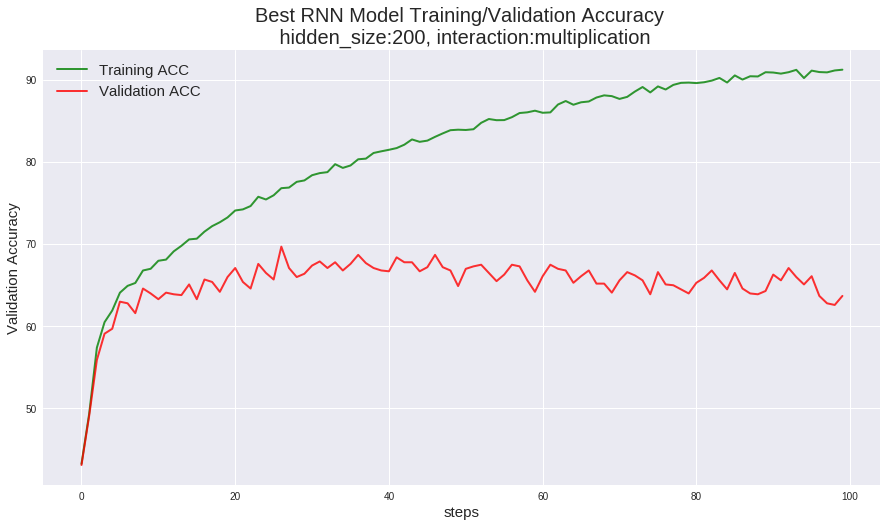

In [85]:
# libraries and data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Make a data frame
 
# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
plt.figure(figsize=(15,8))
# multiple line plot
#num=0
#for i in range(len(df)):
    #num+=1
plt.plot(rnn['Training_ACC'][4], marker='', color="green", linewidth=2, alpha=0.8, label='Training ACC')
plt.plot(rnn['Validation_ACC'][4], marker='', color="red", linewidth=2, alpha=0.8, label='Validation ACC')
 
# Add legend
plt.legend(loc=2, ncol=1, prop={'size': 15})

# Add titles
plt.title("Best RNN Model Training/Validation Accuracy \n hidden_size:{}, interaction:{}".format(rnn['hidden_size'][4],rnn['interaction'][4]), loc='center', fontsize=20, fontweight=0)
plt.xlabel("steps",fontsize=15)
plt.ylabel("Validation Accuracy",fontsize=15)


### Best CNN Model

In [80]:
max(list(cnn['max_val_ACC']))

67.9

In [81]:
best_cnn_model=cnn[cnn['max_val_ACC']==67.9].reset_index()
best_cnn_model

,index,Model,hidden_size,interaction,kernel,Validation_ACC,Training_ACC,max_val_ACC
0,16,CNN,400,concatenation,5,"[54.5, 59.7, 59.7, 63.3, 64.4, 64.9, 63.1, 63....","[54.80859375, 61.01171875, 63.546875, 64.90234...",67.9


Text(0,0.5,'Validation Accuracy')

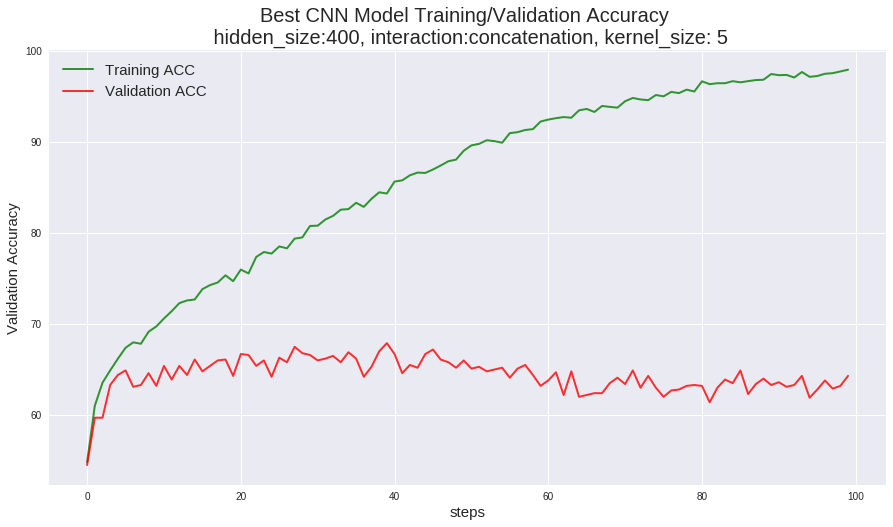

In [84]:
# libraries and data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Make a data frame
 
# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
plt.figure(figsize=(15,8))
# multiple line plot
#num=0
#for i in range(len(df)):
    #num+=1
plt.plot(cnn['Training_ACC'][16], marker='', color="green", linewidth=2, alpha=0.8, label='Training ACC')
plt.plot(cnn['Validation_ACC'][16], marker='', color="red", linewidth=2, alpha=0.8, label='Validation ACC')
 
# Add legend
plt.legend(loc=2, ncol=1, prop={'size': 15})

# Add titles
plt.title("Best CNN Model Training/Validation Accuracy \n hidden_size:{}, interaction:{}, kernel_size: {}".format(cnn['hidden_size'][16],cnn['interaction'][16],cnn['kernel'][16]), loc='center', fontsize=20, fontweight=0)
plt.xlabel("steps",fontsize=15)
plt.ylabel("Validation Accuracy",fontsize=15)

### Groupby Models

In [0]:
def average_acc(df,value):   
    mylist = [df[value][i] for i in range(len(df))]
    mylist = sum(map(np.array, mylist))
    mylist=mylist/len(df)
    return mylist

In [0]:
average_rnn_ACC=average_acc(rnn,'Validation_ACC')
average_cnn_ACC=average_acc(cnn,'Validation_ACC')
# average_rnn_LOSS=average_acc(rnn,'LOSS')
# average_cnn_LOSS=average_acc(cnn,'LOSS')

Text(0,0.5,'Mean Validation Accuracy')

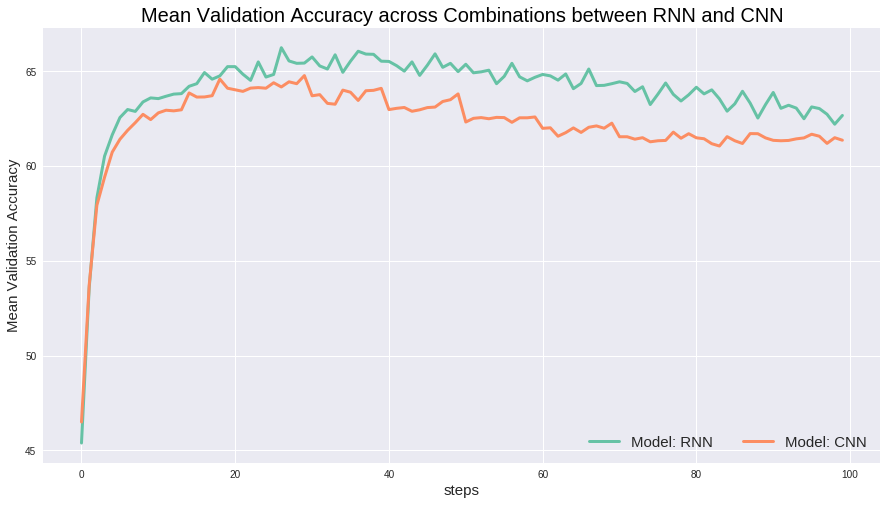

In [88]:
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set2')
plt.figure(figsize=(15,8))

num=0
plt.plot(average_rnn_ACC, marker='', color=palette(num), linewidth=3, alpha=1, label='Model: RNN')
num=1
plt.plot(average_cnn_ACC, marker='', color=palette(num), linewidth=3, alpha=1, label='Model: CNN')

# Add legend
plt.legend(loc=4, ncol=2,prop={'size': 15})

# Add titles
plt.title("Mean Validation Accuracy across Combinations between RNN and CNN", loc='center', fontsize=20, fontweight=0, color='black')
plt.xlabel("steps",fontsize=15)
plt.ylabel("Mean Validation Accuracy",fontsize=15)

### RNN: groupby hideen_size

In [0]:
hidden50=rnn[rnn['hidden_size']==50].reset_index().drop(['index'],axis=1)
hidden100=rnn[rnn['hidden_size']==100].reset_index().drop(['index'],axis=1)
hidden200=rnn[rnn['hidden_size']==200].reset_index().drop(['index'],axis=1)
hidden300=rnn[rnn['hidden_size']==300].reset_index().drop(['index'],axis=1)


In [0]:
average_hidden50_ACC=average_acc(hidden50,'Validation_ACC')
average_hidden100_ACC=average_acc(hidden100,'Validation_ACC')
average_hidden200_ACC=average_acc(hidden200,'Validation_ACC')
average_hidden300_ACC=average_acc(hidden300,'Validation_ACC')

Text(0,0.5,'Mean Validation Accuracy')

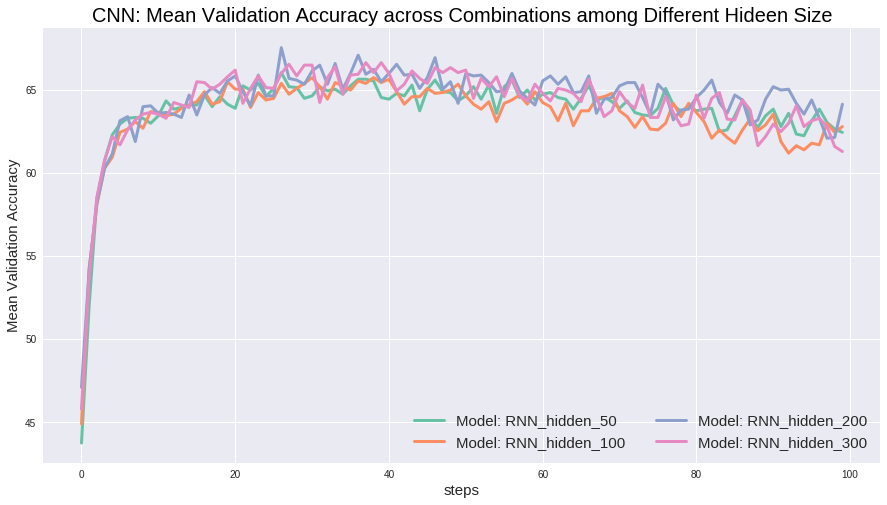

In [92]:
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set2')
plt.figure(figsize=(15,8))

num=0
plt.plot(average_hidden50_ACC, marker='', color=palette(num), linewidth=3, alpha=1, label='Model: RNN_hidden_50')
num=1
plt.plot(average_hidden100_ACC, marker='', color=palette(num), linewidth=3, alpha=1, label='Model: RNN_hidden_100')
num=2
plt.plot(average_hidden200_ACC, marker='', color=palette(num), linewidth=3, alpha=1, label='Model: RNN_hidden_200')
num=3
plt.plot(average_hidden300_ACC, marker='', color=palette(num), linewidth=3, alpha=1, label='Model: RNN_hidden_300')

# Add legend
plt.legend(loc=4, ncol=2,prop={'size': 15})

# Add titles
plt.title("CNN: Mean Validation Accuracy across Combinations among Different Hideen Size", loc='center', fontsize=20, fontweight=0, color='black')
plt.xlabel("steps",fontsize=15)
plt.ylabel("Mean Validation Accuracy",fontsize=15)

### RNN: groupby interaction method

In [0]:
concatenation=rnn[rnn['interaction']=="concatenation"].reset_index().drop(['index'],axis=1)
multiplication=rnn[rnn['interaction']=="multiplication"].reset_index().drop(['index'],axis=1)

average_concatenation_ACC=average_acc(concatenation,'Validation_ACC')
average_multiplication_ACC=average_acc(multiplication,'Validation_ACC')

Text(0,0.5,'Mean Validation Accuracy')

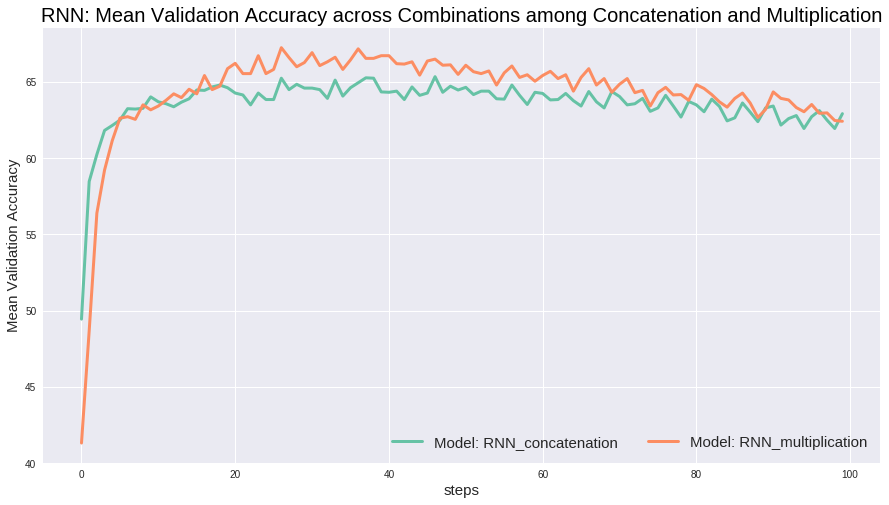

In [94]:
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set2')
plt.figure(figsize=(15,8))

num=0
plt.plot(average_concatenation_ACC, marker='', color=palette(num), linewidth=3, alpha=1, label='Model: RNN_concatenation')
num=1
plt.plot(average_multiplication_ACC, marker='', color=palette(num), linewidth=3, alpha=1, label='Model: RNN_multiplication')


# Add legend
plt.legend(loc=4, ncol=2,prop={'size': 15})

# Add titles
plt.title("RNN: Mean Validation Accuracy across Combinations among Concatenation and Multiplication", loc='center', fontsize=20, fontweight=0, color='black')
plt.xlabel("steps",fontsize=15)
plt.ylabel("Mean Validation Accuracy",fontsize=15)

### CNN: groupby hideen_size

In [0]:
hidden200=cnn[cnn['hidden_size']==200].reset_index().drop(['index'],axis=1)
hidden300=cnn[cnn['hidden_size']==300].reset_index().drop(['index'],axis=1)
hidden400=cnn[cnn['hidden_size']==400].reset_index().drop(['index'],axis=1)

average_hidden200_ACC=average_acc(hidden200,'Validation_ACC')
average_hidden300_ACC=average_acc(hidden300,'Validation_ACC')
average_hidden400_ACC=average_acc(hidden400,'Validation_ACC')

Text(0,0.5,'Mean Validation Accuracy')

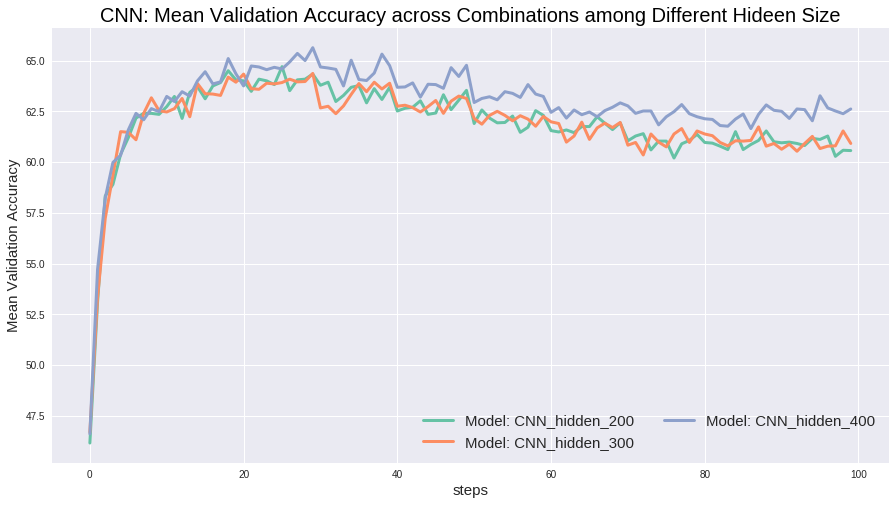

In [96]:
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set2')
plt.figure(figsize=(15,8))

num=0
plt.plot(average_hidden200_ACC, marker='', color=palette(num), linewidth=3, alpha=1, label='Model: CNN_hidden_200')
num=1
plt.plot(average_hidden300_ACC, marker='', color=palette(num), linewidth=3, alpha=1, label='Model: CNN_hidden_300')
num=2
plt.plot(average_hidden400_ACC, marker='', color=palette(num), linewidth=3, alpha=1, label='Model: CNN_hidden_400')


# Add legend
plt.legend(loc=4, ncol=2,prop={'size': 15})

# Add titles
plt.title("CNN: Mean Validation Accuracy across Combinations among Different Hideen Size", loc='center', fontsize=20, fontweight=0, color='black')
plt.xlabel("steps", fontsize=15)
plt.ylabel("Mean Validation Accuracy",fontsize=15)

### CNN: groupby interation method

In [0]:
concatenation=cnn[cnn['interaction']=="concatenation"].reset_index().drop(['index'],axis=1)
multiplication=cnn[cnn['interaction']=="multiplication"].reset_index().drop(['index'],axis=1)

average_concatenation_ACC=average_acc(concatenation,'Validation_ACC')
average_multiplication_ACC=average_acc(multiplication,'Validation_ACC')

Text(0,0.5,'Mean Validation Accuracy')

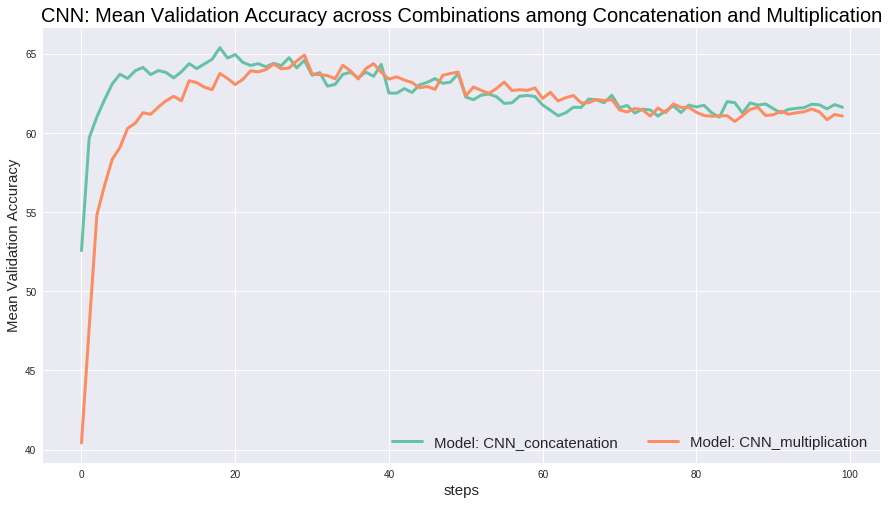

In [98]:
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set2')
plt.figure(figsize=(15,8))

num=0
plt.plot(average_concatenation_ACC, marker='', color=palette(num), linewidth=3, alpha=1, label='Model: CNN_concatenation')
num=1
plt.plot(average_multiplication_ACC, marker='', color=palette(num), linewidth=3, alpha=1, label='Model: CNN_multiplication')


# Add legend
plt.legend(loc=4, ncol=2,prop={'size': 15})

# Add titles
plt.title("CNN: Mean Validation Accuracy across Combinations among Concatenation and Multiplication", loc='center', fontsize=20, fontweight=0, color='black')
plt.xlabel("steps",fontsize=15)
plt.ylabel("Mean Validation Accuracy",fontsize=15)

### CNN: groupby kernel size

In [0]:
kernel3=cnn[cnn['kernel']==3].reset_index().drop(['index'],axis=1)
kernel5=cnn[cnn['kernel']==5].reset_index().drop(['index'],axis=1)
kernel7=cnn[cnn['kernel']==7].reset_index().drop(['index'],axis=1)

average_kernel3_ACC=average_acc(kernel3,'Validation_ACC')
average_kernel5_ACC=average_acc(kernel5,'Validation_ACC')
average_kernel7_ACC=average_acc(kernel7,'Validation_ACC')

Text(0,0.5,'Mean Validation Accuracy')

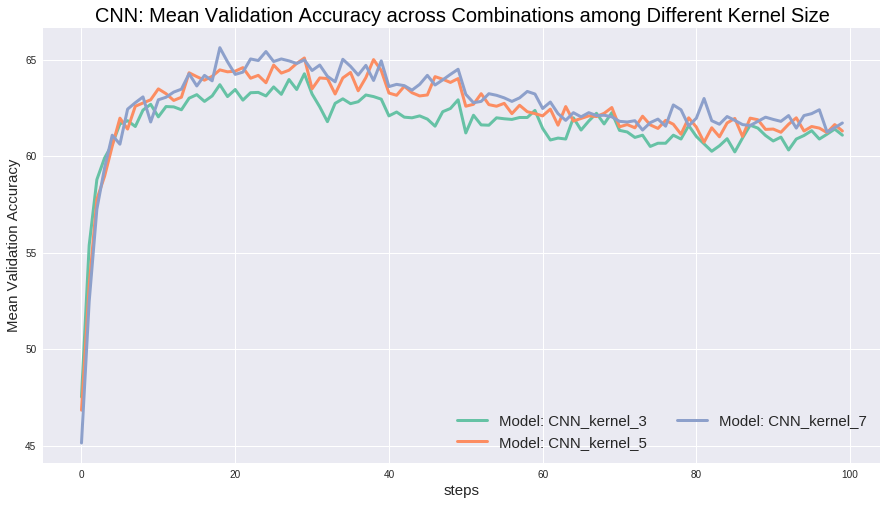

In [100]:
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set2')
plt.figure(figsize=(15,8))

num=0
plt.plot(average_kernel3_ACC, marker='', color=palette(num), linewidth=3, alpha=1, label='Model: CNN_kernel_3')
num=1
plt.plot(average_kernel5_ACC, marker='', color=palette(num), linewidth=3, alpha=1, label='Model: CNN_kernel_5')
num=2
plt.plot(average_kernel7_ACC, marker='', color=palette(num), linewidth=3, alpha=1, label='Model: CNN_kernel_7')


# Add legend
plt.legend(loc=4, ncol=2,prop={'size': 15})

# Add titles
plt.title("CNN: Mean Validation Accuracy across Combinations among Different Kernel Size", loc='center', fontsize=20, fontweight=0, color='black')
plt.xlabel("steps",fontsize=15)
plt.ylabel("Mean Validation Accuracy",fontsize=15)

## 3 correct 3 incorerct examples

In [0]:
val_dataset_best = NewsGroupDataset(val_tuple[0:200])
val_loader_best = torch.utils.data.DataLoader(dataset=val_dataset_best, 
                                           batch_size=200,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

In [129]:
loaded_model = RNN(embedding_matrix, hidden_size=200, num_layers=1, num_classes=3, interacting="multiplication")

loaded_model.load_state_dict(torch.load('/content/drive/My Drive/colab/Rnn/Models_RNN_200_multiplication'))
loaded_model = loaded_model.cuda()
loaded_model.eval()

RNN(
  (embedding): Embedding(100002, 300, padding_idx=0)
  (rnn): GRU(300, 200, batch_first=True, bidirectional=True)
  (linear11): Linear(in_features=800, out_features=200, bias=True)
  (linear12): Linear(in_features=400, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=3, bias=True)
  (relu): ReLU()
)

In [130]:

for data1,data2,lengths1, lengths2, labels in val_loader_best:
    data_batch1,data_batch2, lengths_batch1, lengths_batch2, label_batch = data1,data2,lengths1, lengths2, labels
    outputs = F.softmax(loaded_model(data_batch1,data_batch2, lengths_batch1, lengths_batch2), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    predicted = predicted.cpu()
    labels = labels.cpu()
    
    Incorrect=[i[0] for i in (predicted.eq(labels.view_as(predicted))==0).nonzero().numpy()]
    print("Incorrect Index: " ,Incorrect)
    print([predicted.flatten()[i] for i in Incorrect])
    

Incorrect Index:  [0, 5, 7, 9, 10, 11, 12, 13, 14, 16, 18, 20, 23, 28, 31, 35, 39, 40, 45, 46, 50, 52, 54, 56, 58, 59, 64, 67, 70, 72, 73, 76, 78, 79, 80, 83, 87, 89, 92, 94, 95, 100, 101, 102, 103, 105, 109, 112, 114, 116, 119, 120, 121, 124, 125, 129, 131, 134, 135, 136, 137, 139, 142, 143, 154, 156, 157, 160, 161, 166, 168, 174, 175, 176, 177, 179, 180, 185, 188, 191, 192, 195, 196, 197]
[tensor(2), tensor(1), tensor(2), tensor(2), tensor(0), tensor(1), tensor(2), tensor(2), tensor(0), tensor(2), tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(2), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(0), tensor(0), tensor(2), tensor(2), tensor(1), tensor(1), tensor(0), tensor(1), tensor(2), tensor(0), tensor(1), tensor(0), tensor(0), tensor(1), tensor(0), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(0), tensor(2), tensor(0), tensor(0), tensor(0), tensor(1), tensor(0), tensor(1), tensor(2), tensor(0), tensor(0), tensor(1), 

In [143]:
val_data.head(10)

,sentence1,sentence2,label,Label
0,"Three women on a stage , one wearing red shoes...",There are two women standing on the stage,contradiction,1
1,"Four people sit on a subway two read books , o...","Multiple people are on a subway together , wit...",entailment,2
2,bicycles stationed while a group of people soc...,People get together near a stand of bicycles .,entailment,2
3,Man in overalls with two horses .,a man in overalls with two horses,entailment,2
4,Man observes a wavelength given off by an elec...,The man is examining what wavelength is given ...,entailment,2
5,Two people are in a green forest .,The forest is not dead .,entailment,2
6,Two men are listening to music through headpho...,Two men listen to music .,entailment,2
7,"Two women , one walking her dog the other push...",There is a snowstorm .,contradiction,1
8,A group of numbered participants walk down the...,Participants wait for the beginning of the wal...,neutral,0
9,Three people and a white dog are sitting in th...,Three dogs and a person are sitting in the snow .,contradiction,1


In [132]:
print("premise: ",val_data.iloc[0][0])
print()
print("hypothesis: ", val_data.iloc[0][1])
print()
print("true: ", val_data.iloc[0][3])

print('prediction: ', int(predicted.flatten()[0]))

premise:  Three women on a stage , one wearing red shoes , black pants , and a gray shirt is sitting on a prop , another is sitting on the floor , and the third wearing a black shirt and pants is standing , as a gentleman in the back tunes an instrument .

hypothesis:  There are two women standing on the stage

true:  1
prediction:  2


In [348]:
print("premise: ",val_data.iloc[5][0])
print()
print("hypothesis: ", val_data.iloc[5][1])
print()
print("true: ", val_data.iloc[5][3])

print('prediction: ', int(predicted.flatten()[5]))

premise:  bicycles stationed while a group of people socialize .

hypothesis:  People get together near a stand of bicycles .

true:  2
prediction:  1


In [351]:
print("premise: ",val_data.iloc[40][0])
print()
print("hypothesis: ", val_data.iloc[40][1])
print()
print("true: ", val_data.iloc[40][3])

print('prediction: ', int(predicted.flatten()[40]))

premise:  A boy in sandals is looking at a camera in a busy street .

hypothesis:  A boy is looking at electronics near a road

true:  2
prediction:  0


In [352]:
print("premise: ",val_data.iloc[1][0])
print()
print("hypothesis: ", val_data.iloc[1][1])
print()
print("true: ", val_data.iloc[1][3])
print('prediction: ', int(predicted.flatten()[1]))

premise:  Four people sit on a subway two read books , one looks at a cellphone and is wearing knee high boots .

hypothesis:  Multiple people are on a subway together , with each of them doing their own thing .

true:  2
prediction:  2


In [353]:
print("premise: ",val_data.iloc[24][0])
print()
print("hypothesis: ", val_data.iloc[24][1])
print()
print("true: ", val_data.iloc[24][3])
print('prediction: ', int(predicted.flatten()[24]))

premise:  A live band on a lawn jamming out .

hypothesis:  A band is practicing new tunes in the garage .

true:  1
prediction:  1


In [355]:
print("premise: ",val_data.iloc[47][0])
print()
print("hypothesis: ", val_data.iloc[47][1])
print()
print("true: ", val_data.iloc[47][3])
print('prediction: ', int(predicted.flatten()[47]))

premise:  A gray-haired woman wearing tan pants , a yellow and white jacket and sunglasses is sitting on a bench .

hypothesis:  The woman has gray hair .

true:  2
prediction:  2


# Evaluating on MultiNLI

### Load the best RNN model and the best CNN mdoel

In [133]:
loaded_rnn_model = RNN(embedding_matrix, hidden_size=200, num_layers=1, num_classes=3, interacting="multiplication")

loaded_rnn_model.load_state_dict(torch.load('/content/drive/My Drive/colab/Rnn/Models_RNN_200_multiplication'))
loaded_rnn_model = loaded_rnn_model.cuda()
loaded_rnn_model.eval()
# val_acc = RNN_test_model(val_loader, loaded_model)

RNN(
  (embedding): Embedding(100002, 300, padding_idx=0)
  (rnn): GRU(300, 200, batch_first=True, bidirectional=True)
  (linear11): Linear(in_features=800, out_features=200, bias=True)
  (linear12): Linear(in_features=400, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=3, bias=True)
  (relu): ReLU()
)

In [134]:
loaded_cnn_model = CNN(embedding_matrix, hidden_size=400, num_layers=2, num_classes=3,kernel_size=5, interacting="concatenation")

loaded_cnn_model.load_state_dict(torch.load('/content/drive/My Drive/colab/Cnn/Models_CNN_400_concatenation_5'))
loaded_cnn_model = loaded_cnn_model.cuda()
loaded_cnn_model.eval()
# val_acc = RNN_test_model(val_loader, loaded_model)



CNN(
  (embedding): Embedding(100002, 300, padding_idx=0)
  (conv1): Conv1d(300, 400, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(400, 400, kernel_size=(5,), stride=(1,), padding=(2,))
  (linear11): Linear(in_features=800, out_features=400, bias=True)
  (linear12): Linear(in_features=400, out_features=400, bias=True)
  (linear2): Linear(in_features=400, out_features=3, bias=True)
  (relu): ReLU()
)

In [0]:
#train_data= pd.read_csv('/content/drive/My Drive/colab/snli_train.tsv',delimiter='\t',encoding='utf-8')
multi_val_data=pd.read_csv('/content/drive/My Drive/colab/mnli_val.tsv',delimiter='\t',encoding='utf-8')

In [136]:
list(multi_val_data['genre'].unique())

['fiction', 'telephone', 'slate', 'government', 'travel']

In [0]:
df = multi_val_data[multi_val_data['genre']=='fiction'].reset_index().drop('index',axis=1)

In [0]:
def evaluation(Model):
  result_list=[]
  for i in list(multi_val_data['genre'].unique()):
      df = multi_val_data[multi_val_data['genre']==i].reset_index().drop('index',axis=1)

      val_multi_data=one_hot(df)
      val_multi_indices1 = token2index_dataset(list(val_multi_data['sentence1']))
      val_multi_indices2 = token2index_dataset(list(val_multi_data['sentence2']))
      val_multi_label=val_multi_data['Label']
      val_multi_tuple=tuple_list(val_multi_indices1,val_multi_indices2,val_multi_label)


      MAX_SENTENCE_LENGTH1 = max([len(i.split(" ")) for i in val_multi_data['sentence1']])
      MAX_SENTENCE_LENGTH2 = max([len(i.split(" ")) for i in val_multi_data['sentence2']])

      val_dataset = NewsGroupDataset(val_multi_tuple)
      val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                             batch_size=BATCH_SIZE,
                                             collate_fn=newsgroup_collate_func,
                                             shuffle=True)
      if Model=="RNN":
        loaded_rnn_model.eval()
        result_list.append(RNN_test_model(val_loader, loaded_rnn_model))
        
      if Model=="CNN":
        loaded_cnn_model.eval()
        result_list.append(CNN_test_model(val_loader, loaded_cnn_model))
        
  return result_list
    
  


In [141]:
evaluation("RNN")

[40.60301507537689,
 41.09452736318408,
 40.6187624750499,
 39.074803149606296,
 42.15885947046843]

In [142]:
evaluation("CNN")

[42.71356783919598,
 48.45771144278607,
 42.51497005988024,
 42.32283464566929,
 44.39918533604888]